### Imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import warnings

### Independent Component Analysis Implementation

In [17]:
class ICA():

    def __init__(self, n_components, lr, num_epochs, method="sigmoid", whiten=True,epsilon = 0.1,whitening_method = 'zca'):
        """      
        :param n_components: int, number of components to use in whitening
        :param lr:           float, learning_rate
        :param num_epochs:   int, number of iteratins for fit
        """
        
        self.n_components = n_components
        self.lr = lr
        self.num_epochs = num_epochs
        self.method = method
        self.mean_ = None
        self.mixing_ = None
        self.epsilon = epsilon
        self.whiten_ = whiten
        self.whitening_method = whitening_method
    
    
    def whiten(self, X):
        """
        Centeres and whitens the input matrix X using specified whitening method.
        
        :param X:      input data matrix
        :param method: whitening method, try 'pca' or 'zca'
        
        :return:       preprocessed data matrix X
        """
        #TODO: Center the data
        self.mean_ = np.mean(X,axis=0,keepdims=True)
        X = X - self.mean_
        #TODO: Whiten the data
        S = np.cov(X.T)
        u,s,v = np.linalg.svd(S)
        if(self.whitening_method == 'pca'):
            X_prep = X.dot(np.diag(s**(-1/2)).dot(u[:,:self.n_components])) 
        else:
            X_prep = X.dot(u.dot(np.diag(s**(-1/2)).dot(u)))
            if(self.n_components!=X.shape[1]):
                raise NotImplementedError("For ZCA method please choose full number of components.")
                
    
        return X_prep
    
    
    def g(self, X):
        """
        The CDF function for source signals.
        
        :param x:  input data matrix
        :return:   g(x)
        """
        
        if self.method == "sigmoid":   
            #TODO: Implement sigmoid function
            sig =  1 / (1 + np.exp(-X))
            
        else:
            raise NotImplementedError("No method")
            #TODO: Raise NotImplementedError
        return sig
    
    def log_likelihood(self, X, W_curr):
        """
        Loglikelihood function.
        
        :param X:      input data matrix
        :param W_curr: current parameter-matrix W
        
        :return:       log-likelihood
        """
        loglikelihood = np.sum(np.log( 1 - self.g(np.dot(W_curr.T, X.T)) * self.g(np.dot(W_curr.T, X.T)) )  ) + X.shape[0] * np.log(np.absolute(np.linalg.det(W_curr.T)))
        #TODO: calculate log-likelihood

        
        return loglikelihood
        
        
    def fit(self, X, return_transformed=False):
        """
        Main fit function.
        Calculate parameter-matrix W with gradient ascent and assign it to self
        
        :param X:  input data matrix
        """
        
        n_components=self.n_components
        n_samples, n_features = X.shape
        
        if not self.whiten_ and self.n_components is not None:
            n_components = min(n_samples, n_features)
            warnings.warn('Ignoring n_components with whiten=False.')
        if n_components is None:
            n_components = min(n_samples, n_features)
        if (n_components > min(n_samples, n_features)):
            n_components = min(n_samples, n_features)
            warnings.warn('n_components is too large: it will be set to {}'.fomrat(n_components))
        
        if self.whiten_:
            X = self.whiten(X)
        W = np.asarray(np.random.normal(size=(n_components, n_components)), dtype=X.dtype)
        
        if self.method == "sigmoid":
            #TODO: Update W
            inital_log = self.log_likelihood(X,W)
            for i in range(self.num_epochs):
                temp = self.log_likelihood(X,W)
                print(temp)
                if (temp == -float('inf')):
                    break                        
                W += self.lr*((1-2*self.g(np.dot(W.T,X.T))).dot(X) + np.linalg.inv(W.T))
                
                
        self.mixing_ = W
        
        if return_transformed:
            #TODO: return transformed matrix X         
            if(self.mean_ is not None and self.whitening_method!='pca'):
                return  np.dot(X,self.mixing_.T) + self.mean_
            else:
                return  np.dot(X,self.mixing_.T)
        else:
            return X + self.mean_
                
          


    def fit_transform(self, X):
        """
        Fit and transform input data matrix.
        
        :param X:  input data matrix
        :return:   transformed matrix
        """
       
        return self.fit(X, return_transformed=True)

### Usage Example

-4174.855938532303
-2277.96997312782
-4019.6866262056774
-8656.916252015446
-10608.439166408845
-10617.976280023024
-12834.574800160128
-15577.630931565112
-18618.207017790395
-inf


/home/levon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log


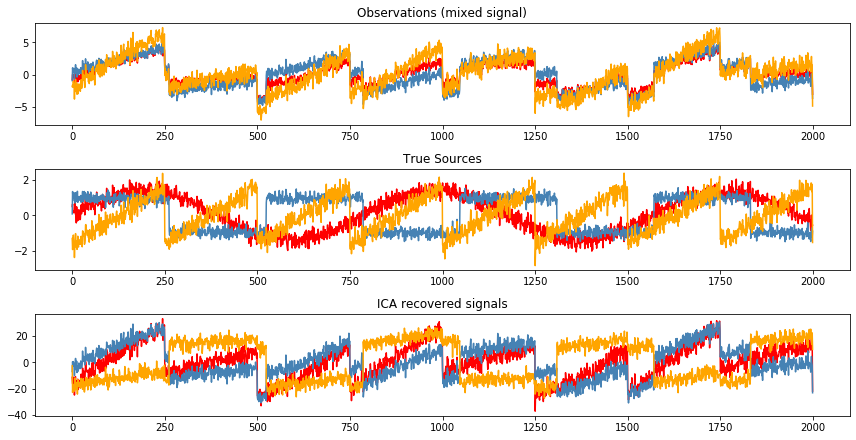

In [18]:
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

# Signal 1 : sinusoidal signal
# Signal 2 : square signal
# Signal 3: saw tooth signal
s1 = np.sin(2 * time)  
s2 = np.sign(np.sin(3 * time)) 
s3 = signal.sawtooth(2 * np.pi * time)  

S = np.c_[s1, s2, s3]

# Add noise
S += 0.2 * np.random.normal(size=S.shape) 

# Standardize data
S /= S.std(axis=0)  

# Mix data with mixing matrix A and assign generated observations to X
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  
X = np.dot(S, A.T)  


# Insert arguments to use your ICA implementation

ica = ICA(3,0.001,1000)
S_ = ica.fit_transform(X)



# Plot results

plt.figure(figsize=(12,8))

models = [X, S, S_]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals']

colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()
